# Loading Dependencies
---

In [ ]:
import sys

try:        
    from google.colab import drive
    drive.mount('/content/gdrive')

    !pip install yfinance
    !pip install pdfplumber
    !rm -rf github
    !mkdir github
    !cd github && git clone https://github.com/dr315/Finances.git
    sys.path.append('/content/github/Finances')
    
    root = '/content/gdrive/MyDrive/'    
except:
    root = 'd:/'

import pandas as pd
pd.options.display.float_format = '${:,.2f}'.format
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from FinanceTools import *
from OrdersReader import *    
ReadOrders(root + 'Investing/Notas_Clear', 'operations.csv', 'Clear') 
# ReadOrders(root + 'Investing/Notas_TD', 'TD.csv', 'TD') 


# Loading and formating table
----

In [ ]:
#Get the complete list of assets
df = pd.read_csv(root + '/Investing/operations.csv')
# df = pd.read_csv(root + '/Investing/TD.csv')
# df = pd.read_csv(root + '/Investing/empiricus.csv')
  
df = df.iloc[:, :7]
df.columns=['Codigo','Data', 'Valor', 'Quantidade', 'Tipo', 'Categoria', 'Despesas']
#drop empty lines
df=df[df['Data'].astype(bool)].dropna()
brTickers = np.sort(df[df['Categoria'].isin(['FII','Ação'])]['Codigo'].unique()).tolist()
usTickers = np.sort(df[df['Categoria'].isin(['Stock', 'REIT'])]['Codigo'].unique()).tolist()

if(df['Valor'].apply(type).eq(str).any()): 
    df['Valor'] = df['Valor'].str.replace(',', '')
    df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')
    df['Quantidade'] = pd.to_numeric(df['Quantidade'], errors='coerce')
    df['Despesas'] = pd.to_numeric(df['Despesas'], errors='coerce')

if(df['Data'].apply(type).eq(str).any()): 
    df['Data'] = df.Data.str.replace('-','/')
    df['Data'] = pd.to_datetime(df['Data'], format='%Y/%m/%d')
df['Year'] = pd.DatetimeIndex(df['Data']).year
df['Month'] = pd.DatetimeIndex(df['Data']).month_name()

#Sort the table by date and Type and reset index numeration
df.sort_values(by=['Data', 'Tipo'], ascending=[True, True], inplace=True)
df.reset_index(drop=True, inplace=True)

#turn all sell amount negative
df.loc[df.Tipo == 'Venda', ['Quantidade']] *= -1

#Get the oldest order date
startDate = df.iloc[0]['Data']

#Calc Operation Value
df['Total'] = df.Valor * df.Quantidade + df.Despesas


In [3]:
# import concurrent.futures
import time
import threading
start_time = time.time()

prcReader = PriceReader(brTickers, usTickers, startDate)
splReader = SplitsReader(df)
divReader = DividendReader(df)
# divReader = YfinanceReader(df)

def threadExecutor(obj):
    obj.load()

threadList = []
threadList.append(threading.Thread(target=threadExecutor, args=(prcReader,)))
threadList.append(threading.Thread(target=threadExecutor, args=(splReader,)))
threadList.append(threading.Thread(target=threadExecutor, args=(divReader,)))

for td in threadList:
    td.start()

for td in threadList:
    td.join()

print("Executed in %s seconds" % (time.time() - start_time))

h:\Git\Finances\FinanceTools.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df.columns = self.df.columns.str.replace('\.SA','')
Executed in 34.7787070274353 seconds


In [ ]:
dfBak = df

In [ ]:
df=dfBak
df['acum_qty'] = 0
df['PM'] = 0
# Clear operation costs befere 2019
# df.Despesas.update(df.apply(clear2018Cost, axis=1))


## Accumulator

In [ ]:

for paper in brTickers:
  paperTable = df[(df.Codigo == paper)]
  fromDate = paperTable.iloc[0]['Data']  
  toDate = dt.datetime.today().strftime('%Y-%m-%d')

  divTable = divReader.getPeriod(paper,fromDate, toDate)
  divTable['Quantidade'] = 0
  divTable['Tipo'] = 'Proventos'
  divTable['Categoria'] = paperTable.iloc[0]['Categoria']
  divTable['Despesas'] = 0
  divTable['Year'] = pd.DatetimeIndex(divTable.index).year
  divTable['Month'] = pd.DatetimeIndex(divTable.index).month_name()
  divTable['Total'] = 0
  divTable['acum_qty'] = 0
  df = df.append(divTable.reset_index())

  splitTable = splReader.getPeriod(paper,fromDate, toDate)
  splitTable['Valor'] = 0
  splitTable['Tipo'] = 'Split'
  splitTable['Categoria'] = paperTable.iloc[0]['Categoria']
  splitTable['Despesas'] = 0
  splitTable['Year'] = pd.DatetimeIndex(splitTable.index).year
  splitTable['Month'] = pd.DatetimeIndex(splitTable.index).month_name()
  splitTable['Total'] = 0
  splitTable['acum_qty'] = 0
  df = df.append(splitTable.reset_index())

df.sort_values(['Data', 'Tipo'], inplace=True)

#Create obj
ta = TableAccumulator()
#Calc the average price and rename the columns names
df=df.groupby(['Codigo']).apply(ta.ByGroup).reset_index(drop=True).dropna()
df.sort_values(['Data', 'Tipo'], inplace=True)

In [ ]:
# df[df.Codigo.str.contains('CIEL3')]

# Realized Profit


## Processing

In [ ]:
def CalcProfit(dtf):
    profit = Profit()
    dtf.sort_values(by=['Data', 'Tipo'], ascending=[True, True], inplace=True)
    dtf.reset_index(drop=True)
    return dtf.groupby(['Codigo', 'Data']).apply(profit.Trade).reset_index(drop=True)


In [9]:
df = CalcProfit(df)
rl = df[df.Tipo == 'Venda'][['Data',	'Codigo', 'Categoria', 'Profit',	'DayTrade']]
rl['Data'] = rl['Data'].apply(lambda x: x.strftime('%Y-%m-%d'))
rl.loc['Total', 'Profit'] = rl['Profit'].sum()
rl.fillna(' ', inplace=True)
rl.style.applymap(color_negative_red, subset=['Profit']).format( {'Profit': 'R$ {:,.2f}', 'DayTrade': '{}'})


,Data,Codigo,Categoria,Profit,DayTrade
10,2018-03-20,KLBN11,Ação,R$ 10.28,0.0
16,2018-04-02,BMEB4,Ação,R$ 2.87,0.0
19,2018-04-04,MOVI3,Ação,R$ 32.70,0.0
20,2018-04-04,MOVI3,Ação,R$ 32.70,0.0
21,2018-04-05,ECOR3,Ação,R$ 111.21,0.0
27,2018-04-20,PETR4,Ação,R$ 35.90,0.0
39,2018-05-09,MFII11,FII,R$ 72.94,0.0
40,2018-05-09,MFII11,FII,R$ 20.15,0.0
43,2018-05-15,XPML11,FII,R$ -2.40,0.0
44,2018-05-15,XPML11,FII,R$ -2.40,0.0


# Portifolio


In [10]:

Portifolio(prcReader,df).show()


,PM,Cotacao,Quantidade,Custo,Valor,Proventos,Rentabilidade,Lucro,%R,%R+d,Alocacao
Ativo,,,,,,,,,,,
ABEV3,R$ 11.15,R$ 15.85,500,"R$ 5,574.73","R$ 7,925.00",R$ 214.17,"R$ 2,350.27","R$ 2,564.45",42.16%,46.00%,4.54%
BBDC3,R$ 20.09,R$ 20.70,220,"R$ 4,419.33","R$ 4,554.00",R$ 12.14,R$ 134.67,R$ 146.81,3.05%,3.32%,2.61%
CIEL3,R$ 7.05,R$ 3.75,3451,"R$ 24,346.40","R$ 12,941.25","R$ 1,199.13","R$ -11,405.15","R$ -10,206.03",-46.85%,-41.92%,7.41%
COGN3,R$ 7.87,R$ 3.96,1050,"R$ 8,261.20","R$ 4,158.00",R$ 133.65,"R$ -4,103.20","R$ -3,969.55",-49.67%,-48.05%,2.38%
EGIE3,R$ 41.51,R$ 42.21,100,"R$ 4,151.32","R$ 4,221.00",R$ 315.63,R$ 69.68,R$ 385.31,1.68%,9.28%,2.42%
EZTC3,R$ 34.36,R$ 34.34,200,"R$ 6,871.10","R$ 6,868.00",R$ 29.41,R$ -3.10,R$ 26.31,-0.05%,0.38%,3.93%
FAMB11B,R$ 1480.50,"R$ 1,211.50",5,"R$ 7,402.48","R$ 6,057.50",R$ 9.16,"R$ -1,344.98","R$ -1,335.82",-18.17%,-18.05%,3.47%
FLRY3,R$ 25.40,R$ 26.31,100,"R$ 2,539.80","R$ 2,631.00",R$ 141.38,R$ 91.20,R$ 232.58,3.59%,9.16%,1.51%
GRND3,R$ 7.22,R$ 8.08,1274,"R$ 9,192.85","R$ 10,293.92",R$ 965.89,"R$ 1,101.07","R$ 2,066.96",11.98%,22.48%,5.90%


# Performance Blueprint

In [11]:

p = PerformanceBlueprint(prcReader, df, dt.datetime.today().strftime('%m-%d-%Y'))
PerformanceViewer(p.calc()).show()


,Value R$,%C
Item,,
Equity,"174,610.88",86.4%
Cost,"202,179.72",100.0%
Expenses,117.90,0.1%
Paper profit,"-27,568.84",-13.6%
Realized profit,"17,117.74",8.5%
Dividends,"19,838.83",9.8%
Total Profit,"9,387.72",4.6%


# Taxation


In [ ]:
profitLossDF = df.loc[df['Profit'] != 0]
tx = Taxation(profitLossDF)

## FII
### Swing Trade

In [ ]:
tx.Process('FII')
try:
    display(tx.swingTradeTable)
except:
  print('Not avalilable')

### Day Trade

In [ ]:
try:
  display(tx.dayTradeTable)
except:
  print('Not avalilable')

## Stocks
### Swing Trade


In [ ]:
tx.Process('Ação')
try:
    display(tx.swingTradeTable)
except:
  print('Not avalilable')    

### Day Trade

In [ ]:
try:
  display(tx.dayTradeTable)
except:
  print('Not avalilable')

# Plots

In [17]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
items = brTickers + usTickers
 
stock_picker = widgets.Dropdown(options=items, value=items[0])
stock_picker

Dropdown(options=('ABEV3', 'BBDC3', 'BBFI11B', 'BMEB4', 'CIEL3', 'COGN3', 'ECOR3', 'EGIE3', 'EZTC3', 'FAMB11B'…

## Average price Evolution

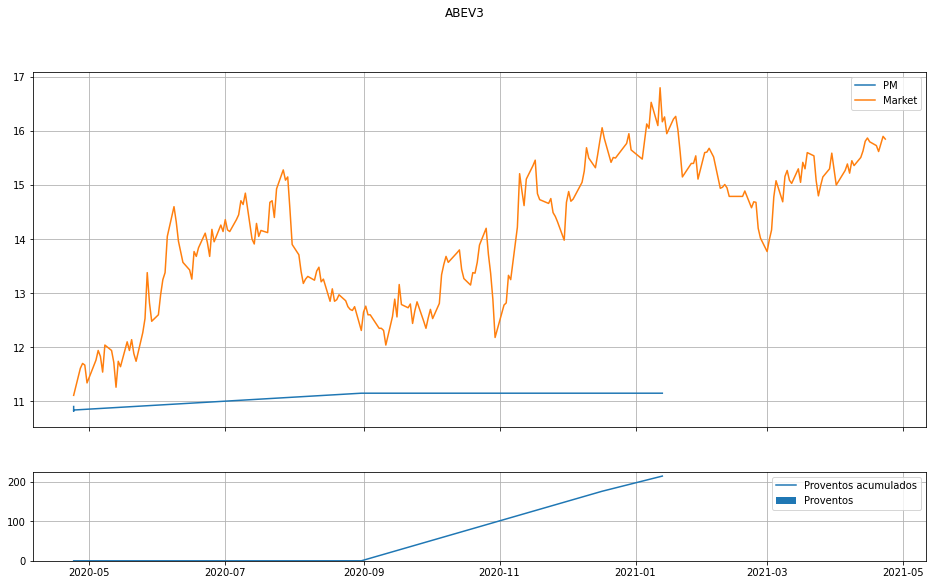

In [18]:
stock = stock_picker.value

fig, axs = plt.subplots(2, 1, figsize=(16, 9), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
pickedDF = df.loc[df.Codigo == stock]

div = pickedDF.loc[pickedDF.Tipo == 'Proventos']

prc = prcReader.getHistory([stock], pickedDF.iloc[0]['Data'].strftime('%d-%m-%y'))
axs[0].plot(pickedDF.Data, pickedDF.PM, label='PM')
axs[0].plot(prc.index, prc[stock], label='Market')
axs[0].grid(True, which='both')
axs[0].legend()

axs[1].plot(pickedDF.Data, pickedDF.acumProv, label='Proventos acumulados')
axs[1].bar(div.Data, div.Valor, label='Proventos')
axs[1].grid(True, which='both')
axs[1].legend()

fig.suptitle(stock)
plt.show()

## Historical profitability

In [35]:
periodPicker = widgets.Dropdown(options=['1 year', '2 years', 'All'], value='1 year')
periodPicker


Dropdown(options=('1 year', '2 years', 'All'), value='1 year')

In [36]:
startPlot = startDate
frequency = 'SM'

if(periodPicker.value != 'All'):
    frequency = 'W'  
    days = int(periodPicker.value.split(' ')[0]) * 365
    startPlot = (dt.datetime.today() - pd.Timedelta(days, unit='d')).strftime('%Y-%m-%d')   
    # df = df[df['Data'] >= startPlot]    

monthList = pd.date_range(start=startPlot, end=dt.datetime.today(), freq=frequency).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
monthList.append(dt.datetime.today().strftime('%Y-%m-%d'))
performanceList = []
for i, month in enumerate(monthList):
  p = PerformanceBlueprint(prcReader, df, month)
  p.calc()
  performanceList.append([p.date, p.equity, p.cost, p.realizedProfit, p.div, p.paperProfit, p.profit, p.profitRate, p.expense, p.ibov, p.sp500])

histProfDF = pd.DataFrame(performanceList, columns=['Date', 'Equity', 'Cost', 'Profit', 'Div', 'paperProfit', 'TotalProfit', '%Profit', 'Expense', '%IBOV', '%SP500'])
histProfDF['Date'] = pd.to_datetime(histProfDF.Date, format='%Y/%m/%d')
# if (startTimePicker.value == "12 months"):
# histProfDF['%IBOV']   = histProfDF['%IBOV'] - histProfDF.iloc[0]['%IBOV']
# histProfDF['%SP500']  = histProfDF['%SP500'] - histProfDF.iloc[0]['%SP500']
# histProfDF['%Profit'] = histProfDF['%Profit'] - histProfDF.iloc[0]['%Profit']
# histProfDF

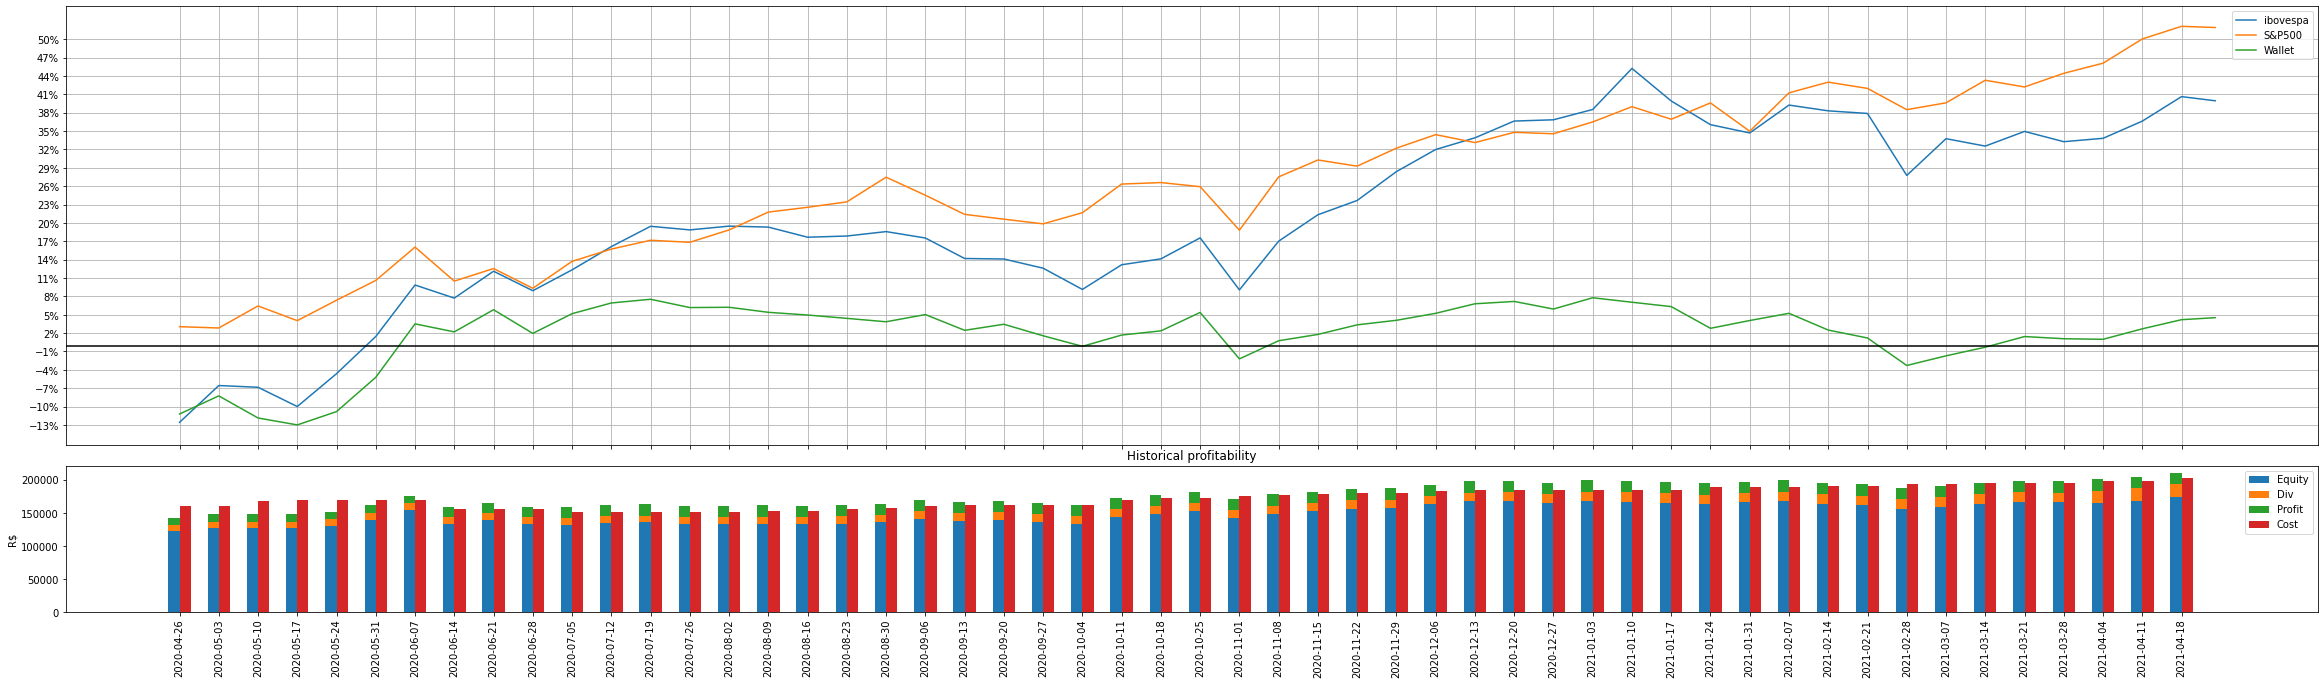

In [37]:
import matplotlib.ticker as mtick

width = 2 if frequency == 'W' else 5     # the width of the bars: can also be len(x) sequence
shift = pd.Timedelta(width/2, unit='d')
fig, ax = plt.subplots(2, 1, figsize=(32, 9), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout()

ax[0].plot(histProfDF.Date, histProfDF['%IBOV'], label='ibovespa')
ax[0].plot(histProfDF.Date, histProfDF['%SP500'], label='S&P500')
ax[0].plot(histProfDF.Date, histProfDF['%Profit'], label='Wallet')

minTick = min(histProfDF['%IBOV'].min(), histProfDF['%SP500'].min(), histProfDF['%Profit'].min())
maxTick = max(histProfDF['%IBOV'].max(), histProfDF['%SP500'].max(), histProfDF['%Profit'].max())

ax[0].set_yticks(np.arange(minTick, maxTick, 0.03))
ax[0].axhline(y=0, color='k')
ax[0].grid(True, which='both')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].legend()

barsDf = histProfDF[:-1]
# ax[1].grid(True, which='both')
ax[1].bar(barsDf.Date - shift, barsDf['Equity'], width, label='Equity')
ax[1].bar(barsDf.Date - shift, barsDf['Div']   , width, bottom=barsDf['Equity'], label='Div')
ax[1].bar(barsDf.Date - shift, barsDf['Profit'], width, bottom=barsDf['Div'] + barsDf['Equity'], label='Profit')
ax[1].bar(barsDf.Date + shift, barsDf['Cost']  , width, label='Cost')
ax[1].legend()
ax[1].set_ylabel('R$')

plt.xticks(barsDf['Date'], rotation=90)
plt.title('Historical profitability')
plt.show()

In [38]:
data = dt.datetime.today().strftime('%Y-%m-%d')
PerformanceViewer(histProfDF, data).show()


,Value R$,%C
Item,,
Equity,"174,610.88",86.4%
Cost,"202,179.72",100.0%
Expenses,117.90,0.1%
Paper profit,"-27,568.84",-13.6%
Realized profit,"17,117.74",8.5%
Dividends,"19,838.83",9.8%
Total Profit,"9,387.72",4.6%


# Dividends by month

In [49]:
m = int(dt.datetime.today().strftime("%m"))
y = int(dt.datetime.today().strftime("%Y"))
# m=6

divTable = divReader.df
prov = df[df['Tipo'] == 'Proventos']

if(not (divTable.empty & prov.empty)):
    divTable = divTable.reset_index()
    divTable = divTable[(divTable['Data de Pagamento'].dt.month == m) & (divTable['Data de Pagamento'].dt.year == y)]

    divTable= pd.merge(divTable, prov, how='inner', on=['Data', 'Codigo', 'Valor'])

    divTable = divTable[['Data de Pagamento', 'Codigo','Total']]
    divTable.columns = ['Data', 'Ativo', 'R$']
    # divTable = divTable.groupby(['Ativo', 'Data'])['R$'].sum().reset_index()
    # display(divTable)
    divTable.sort_values('Data', inplace=True)
    divTable['Data'] = divTable['Data'].apply(lambda x: x.strftime('%Y-%m-%d'))
    divTable.loc['Total', 'R$'] = divTable['R$'].sum()
    divTable.fillna(' ', inplace=True)
    display(divTable)


,Data,Ativo,R$
2,2021-04-01,ITUB3,$3.00
3,2021-04-01,BBDC3,$2.92
4,2021-04-01,FLRY3,$49.44
9,2021-04-08,SPTW11,$118.45
10,2021-04-08,SPTW11,$246.10
7,2021-04-12,PSSA3,$171.01
8,2021-04-12,PSSA3,$95.31
5,2021-04-15,GTWR11,$8.04
6,2021-04-15,MXRF11,$16.00
11,2021-04-15,VISC11,$10.62


In [50]:
if(not prov.empty):
    pvt = prov.pivot_table(index='Year', columns='Month', values='Total', margins=True, margins_name='Total', aggfunc='sum', fill_value=0)
    sorted_m = sorted(pvt.columns[:-1], key=lambda month: dt.datetime.strptime(month, "%B"))
    sorted_m.append(pvt.columns[-1])
    display(pvt.reindex(sorted_m, axis=1))